* This notebook was made to investigate when mixing in the river is dominant by tides and when by river-induced mixing or winds in an averaged sense and also at different instantaneous time.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import StraTimeSeries as sts
import DetermineEdgePlume as DEP
import R_mixStuff as RS
from R_mixStuff import sites
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [3]:
## load grid_T model results
octriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
mayriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_T.nc')
janriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_T.nc')

octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')

octnowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
maynowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc')
jannowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_T.nc')

octnotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
maynotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015notides/may2015notides_T.nc')
jannotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016notides/jan2016notides_T.nc')

In [4]:
def get_Rmix(gridT1,gridT2,gridT3,gridT4,gridT5,tst,ted,dep_ind):
    """This function was made to get the time averaged Rmix"""
    rmix = {};
    for grid_T,st,in zip([gridT1,gridT2,gridT3,gridT4,gridT5],['onlyriver','river+tides',\
                        'river+winds','nof','all']):
        S = grid_T.variables['vosaline']
        lon = grid_T.variables['nav_lon']
        dep = grid_T.variables['deptht']

        S_ave = np.nanmean(S[tst:ted+1],axis = 0)
        rmix[st] = RS.R_mixAve(S_ave,np_mask,dep_ind)
    return rmix

In [5]:
def salinity_profile_update(grid_T,tst,ted,dep_ind,np_mask,string,rmin = 0,rmax =1.0 ):
    """This function was to plot salinity transect and Rmix mainly in the river for 
    winds, tides, and all cases that should be selected"""
    fig = plt.figure(figsize=(16, 6))
    G = gridspec.GridSpec(2, 2,width_ratios=[1, 1], height_ratios=[1,1]) 
    G.update(hspace=0., wspace=0.3)
    axes_1 =fig.add_subplot(G[0,0]) ## rmix
    axes_2 = fig.add_subplot(G[1,0],sharex=axes_1) ## salinity profile
    axes_3 = fig.add_subplot(G[:,1]) ## whole contour
    plt.setp(axes_1.get_xticklabels(), visible=False)
    S_small = {};

    S = grid_T.variables['vosaline']
    S_small[string] =np.ma.masked_array(np.nanmean(S[tst:ted+1,:,36,4:123],axis=0),mask =np_mask[:,36,4:123])
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    mesh = axes_2.contourf(lon[36,4:123],dep[:],S_small[string][:],np.arange(0,34,1),cmap='jet')
    axes_2.set_ylim([dep[-20],dep[0]])
    axes_2.set_xlim([lon[36,4],lon[36,123]])
    
    S_ave =np.ma.masked_array(np.nanmean(S[tst:ted+1],axis=0),mask = np_mask)
    mesh = axes_3.contourf(lon[:],lat[:],S_ave[0],np.arange(0,34,1),cmap='jet')
    cbar = fig.colorbar(mesh,ax = axes_3,orientation = 'vertical')
    axes_3.plot(lon[36,4:123],lat[36,4:123],'k-')    
    viz_tools.plot_land_mask(axes_3,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(axes_3, grid6, coords = 'map')
    axes_3.set_xlim([-124.,-122.8])
    axes_3.set_ylim([48.9,49.5])
    axes_3.set_title(string)
    
    r_mix = get_Rmix(grid_T,grid_T,grid_T,grid_T,grid_T,tst,ted,dep_ind)
    axes_1.plot(lon[36,4:123],r_mix[string][36,4:123],'r-*')
    axes_1.set_ylim([rmin,rmax])
    axes_1.set_title(string)
    return r_mix, S_ave

(48.95, 49.3)

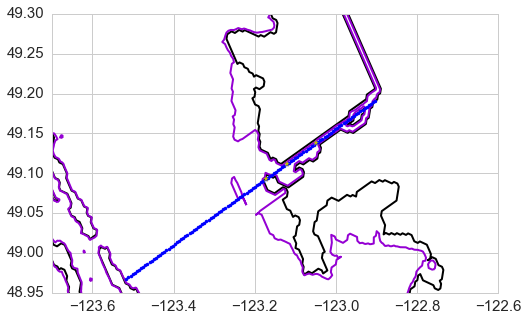

In [6]:
fig, ax = plt.subplots(1,1,figsize = (8,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
lon = octall_T.variables['nav_lon']
lat = octall_T.variables['nav_lat']
ax.plot(lon[36,4:123],lat[36,4:123],'b.')
ax.plot(lon[36,94],lat[36,94],'y*')
ax.plot(lon[36,70],lat[36,70],'y*')
ax.plot(lon[36,80],lat[36,80],'y*')
ax.set_xlim([-123.7,-122.6])
ax.set_ylim([48.95,49.3])

* Don't look at the averaged mixing in the river, as salt-wedge propagation is moved out.

* At instantaneous time

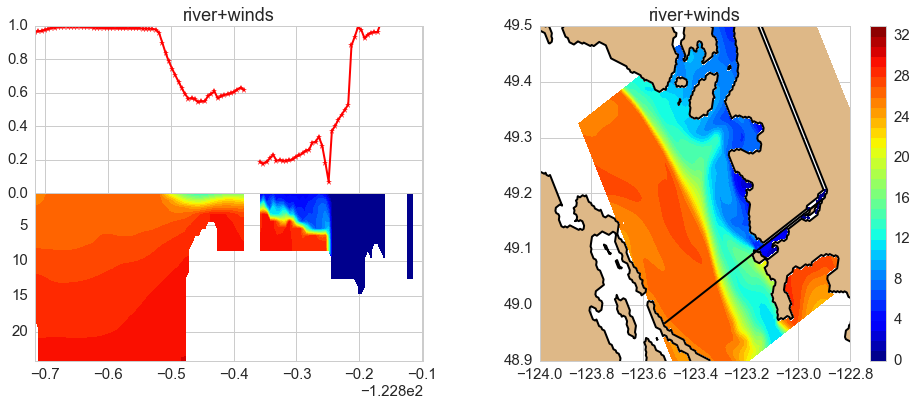

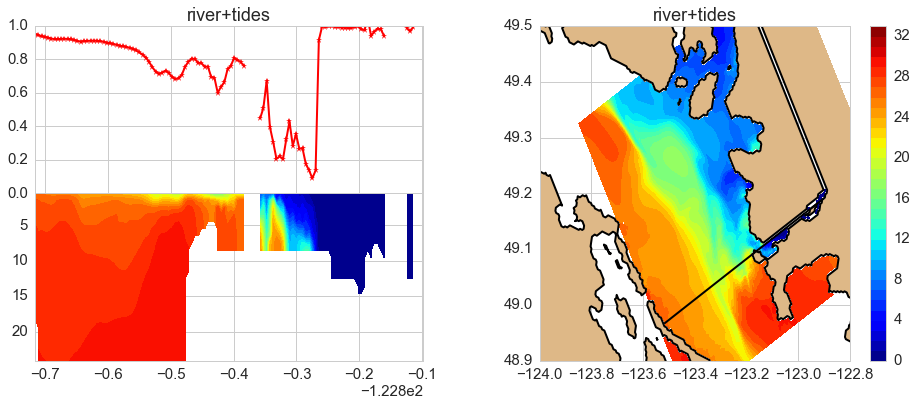

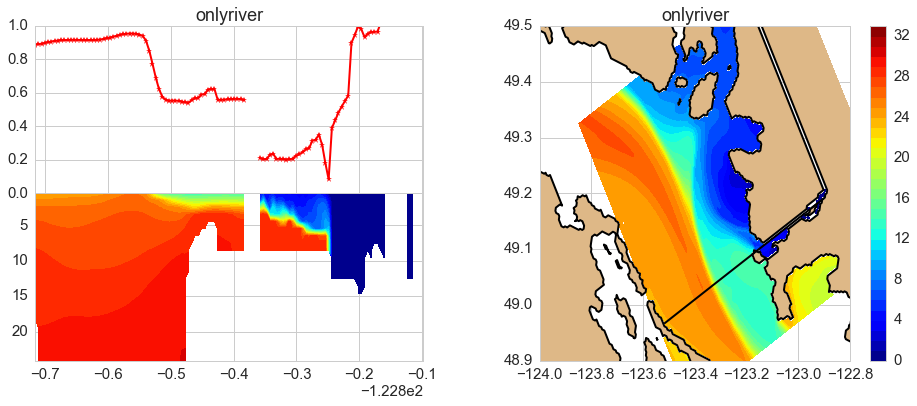

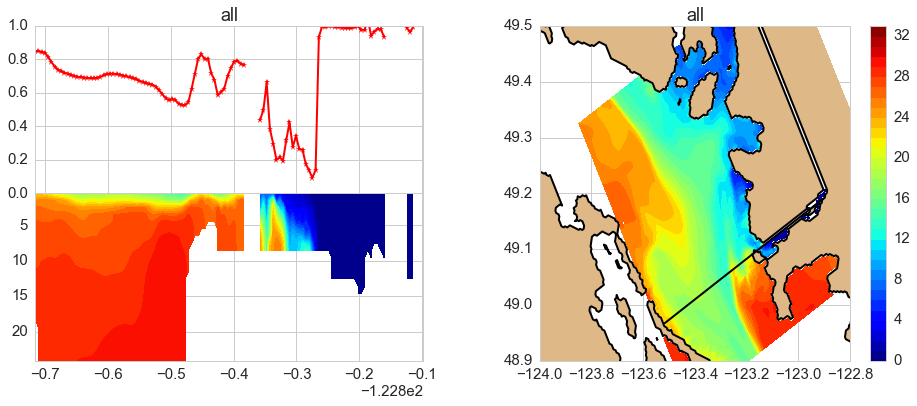

In [8]:
## instantaneous time in October, peak ebb
r_winds, S_ave_wind = salinity_profile_update(octnotide_T,196,196,10,np_mask,'river+winds')
r_tide,S_ave_tide = salinity_profile_update(octnowind_T,196,196,10,np_mask,'river+tides')
r_river,S_ave_river = salinity_profile_update(octriver_T,196,196,10,np_mask,'onlyriver')
r_all,S_ave_all = salinity_profile_update(octall_T,196,196,10,np_mask,'all')

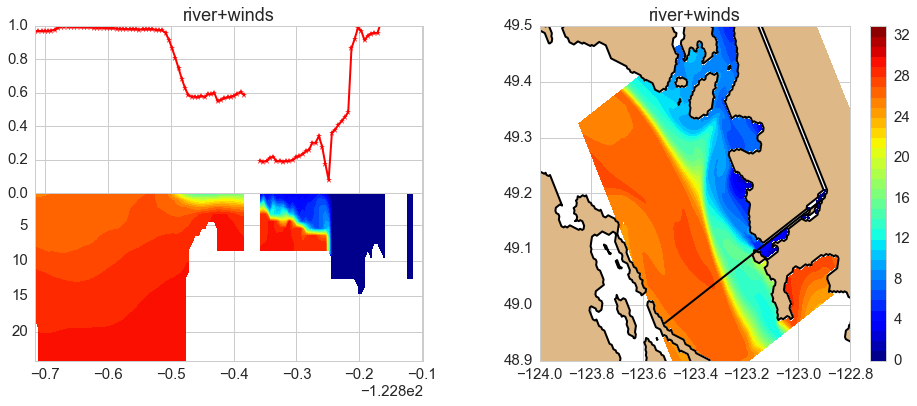

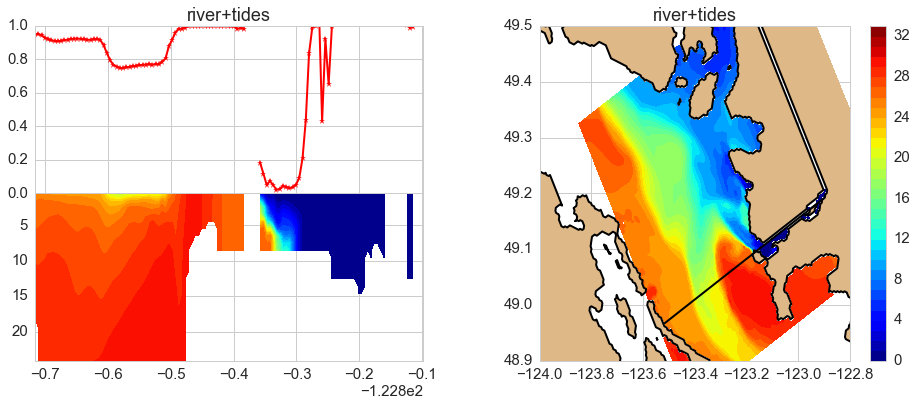

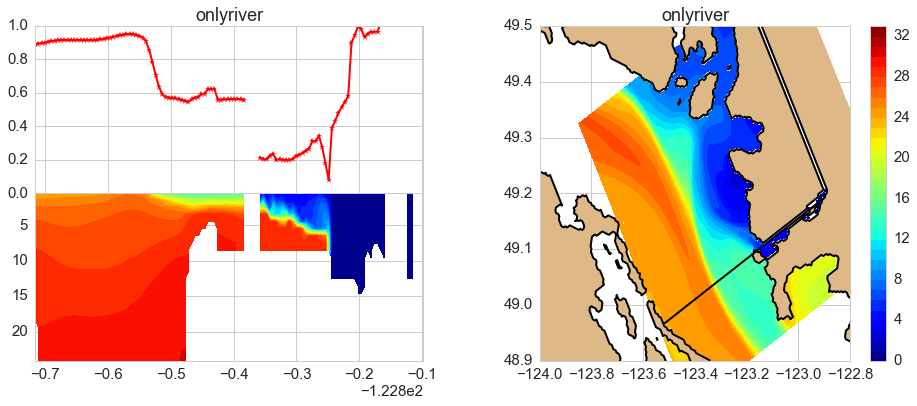

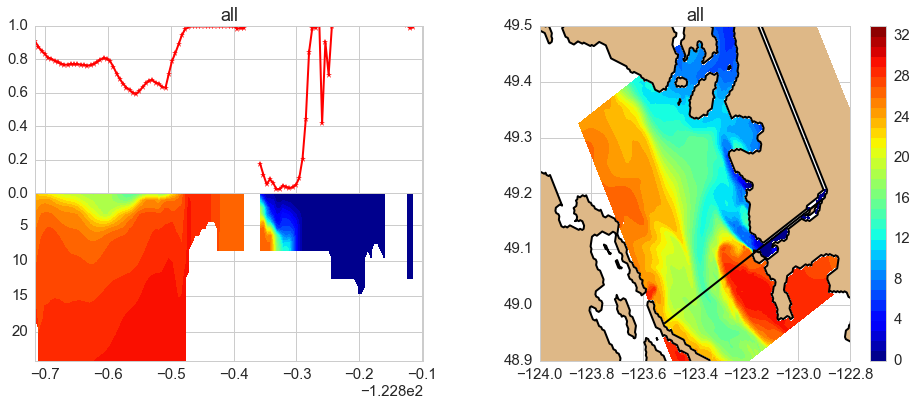

In [9]:
## instantaneous time in October, peak flood
r_winds, S_ave_wind = salinity_profile_update(octnotide_T,202,202,10,np_mask,'river+winds')
r_tide,S_ave_tide = salinity_profile_update(octnowind_T,202,202,10,np_mask,'river+tides')
r_river,S_ave_river = salinity_profile_update(octriver_T,202,202,10,np_mask,'onlyriver')
r_all,S_ave_all = salinity_profile_update(octall_T,202,202,10,np_mask,'all')

* Tidal mixing dominants in the river.
* Peak ebb, more mixing.
* Peak flood, less mixing.

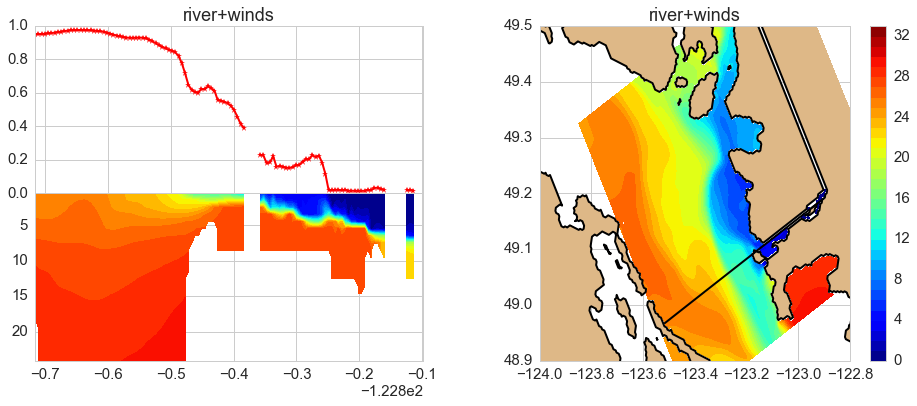

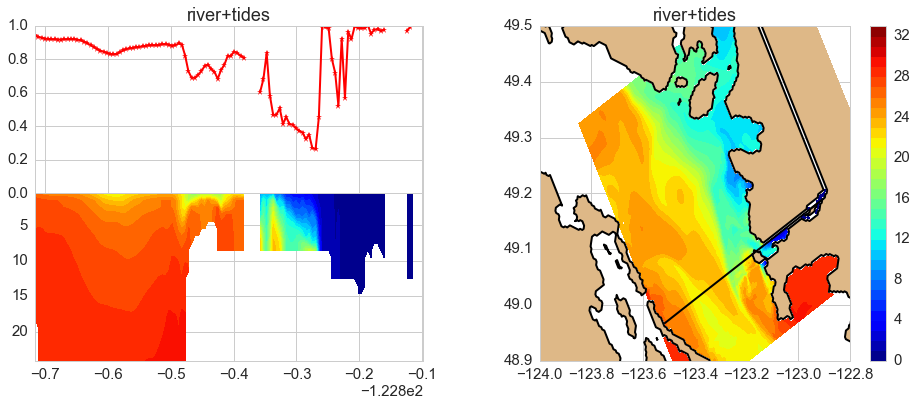

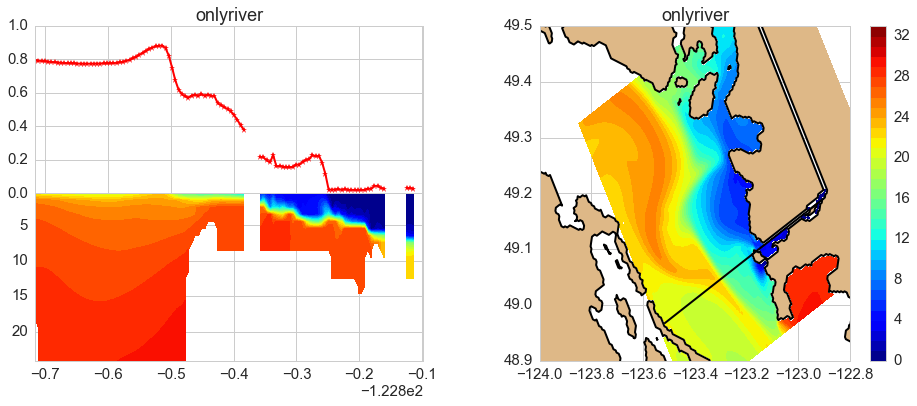

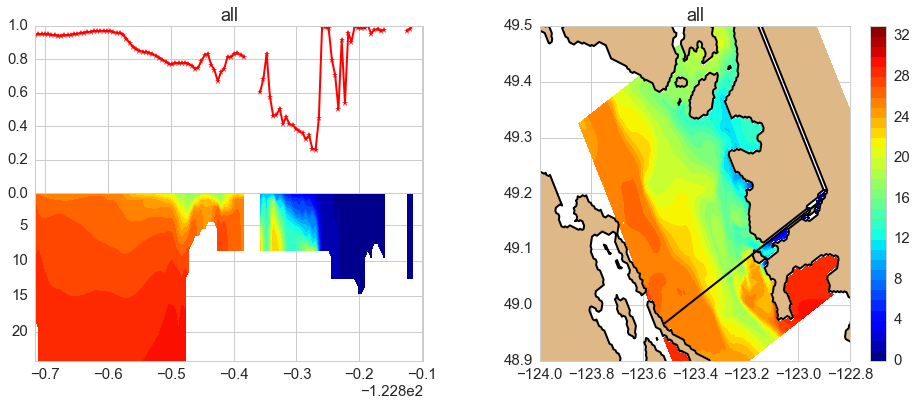

In [10]:
## instantaneous time in Jan, peak ebb
r_winds, S_ave_wind = salinity_profile_update(jannotide_T,195,195,10,np_mask,'river+winds')
r_tide,S_ave_tide = salinity_profile_update(jannowind_T,195,195,10,np_mask,'river+tides')
r_river,S_ave_river = salinity_profile_update(janriver_T,195,195,10,np_mask,'onlyriver')
r_all,S_ave_all = salinity_profile_update(janall_T,195,195,10,np_mask,'all')

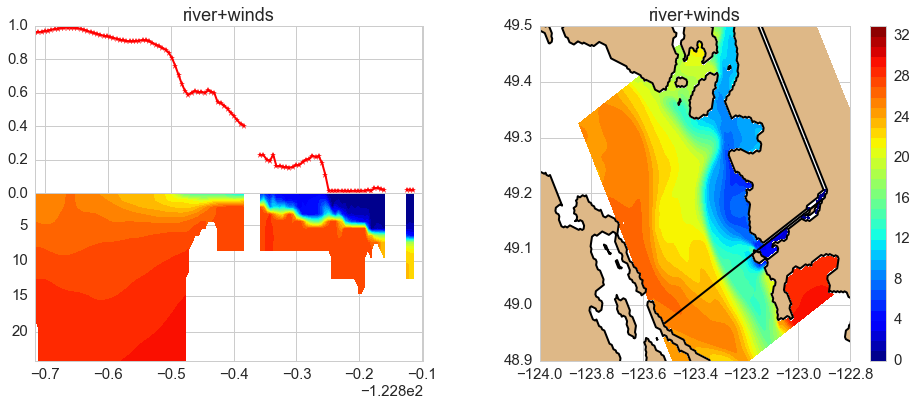

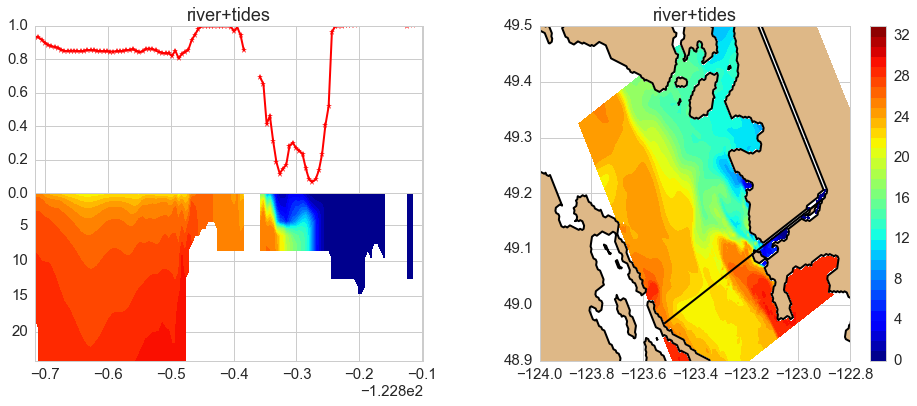

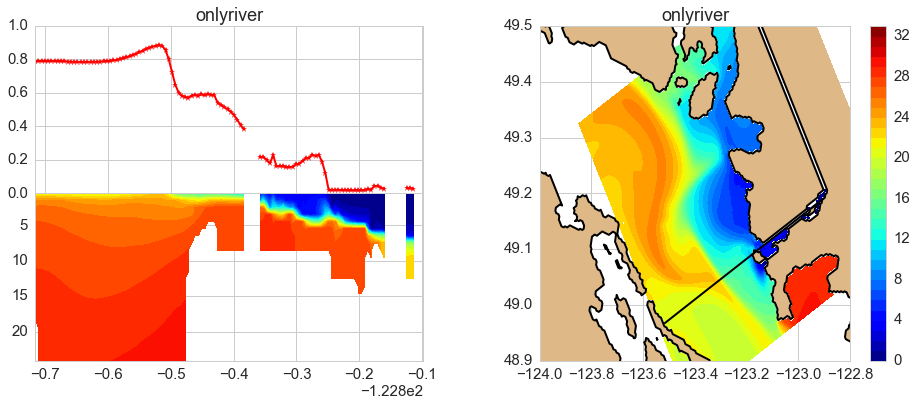

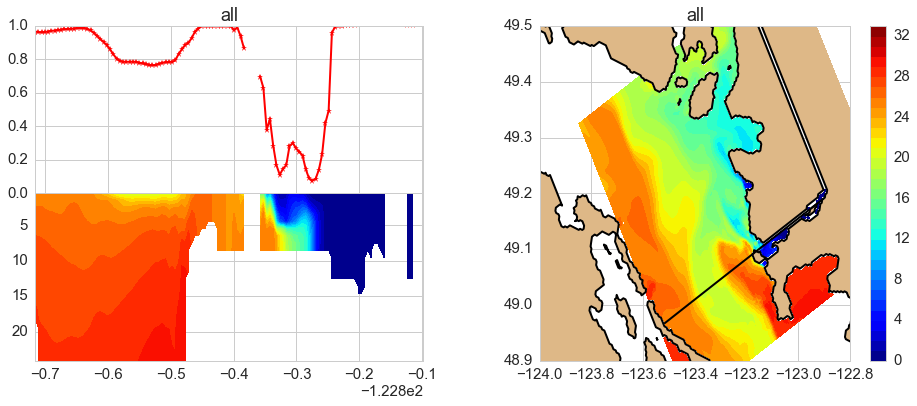

In [11]:
## instantaneous time in Jan, peak flood
r_winds, S_ave_wind = salinity_profile_update(jannotide_T,202,202,10,np_mask,'river+winds')
r_tide,S_ave_tide = salinity_profile_update(jannowind_T,202,202,10,np_mask,'river+tides')
r_river,S_ave_river = salinity_profile_update(janriver_T,202,202,10,np_mask,'onlyriver')
r_all,S_ave_all = salinity_profile_update(janall_T,202,202,10,np_mask,'all')

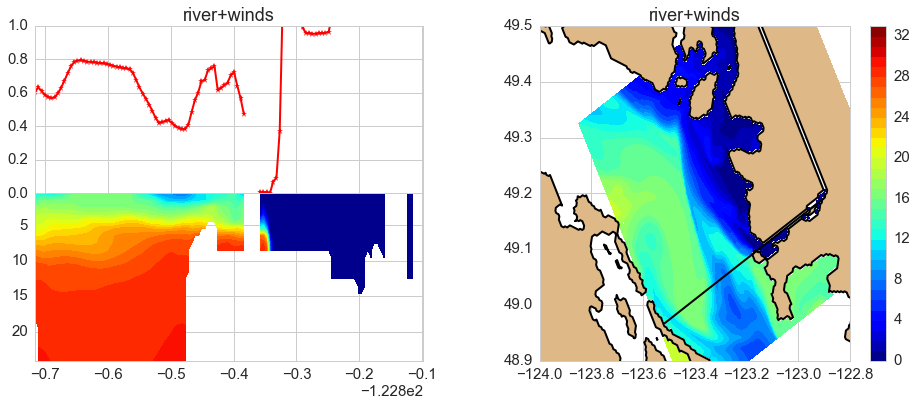

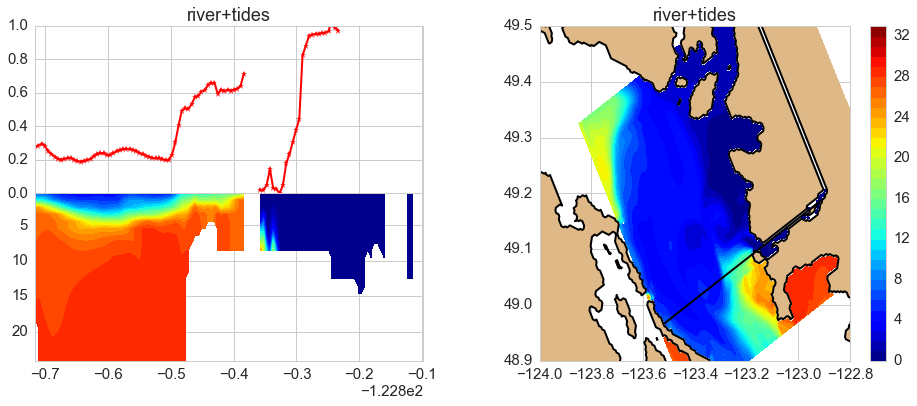

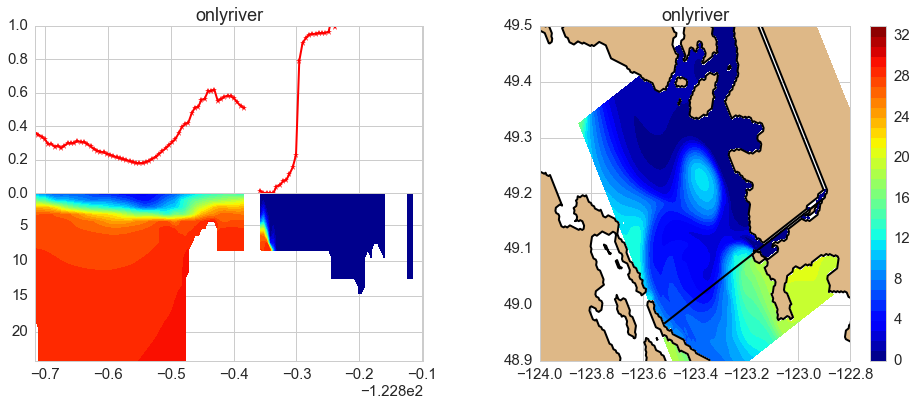

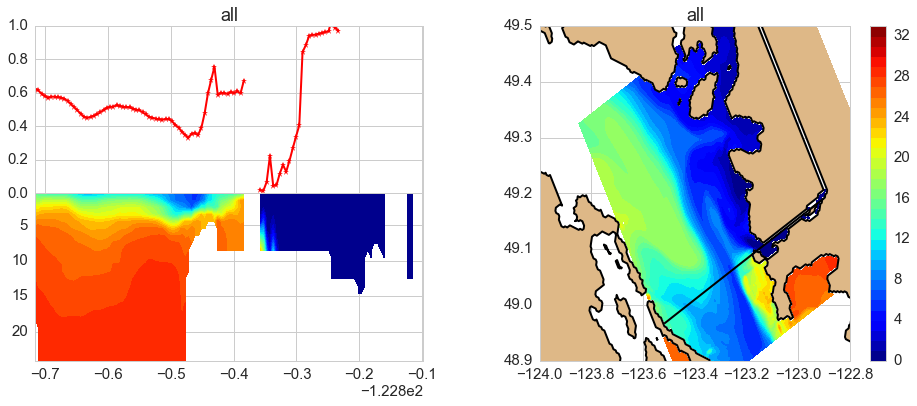

In [12]:
## instantaneous time in May, peak ebb
r_winds, S_ave_wind = salinity_profile_update(maynotide_T,734,734,10,np_mask,'river+winds')
r_tide,S_ave_tide = salinity_profile_update(maynowind_T,734,734,10,np_mask,'river+tides')
r_river,S_ave_river = salinity_profile_update(mayriver_T,734,734,10,np_mask,'onlyriver')
r_all,S_ave_all = salinity_profile_update(mayall_T,734,734,10,np_mask,'all')

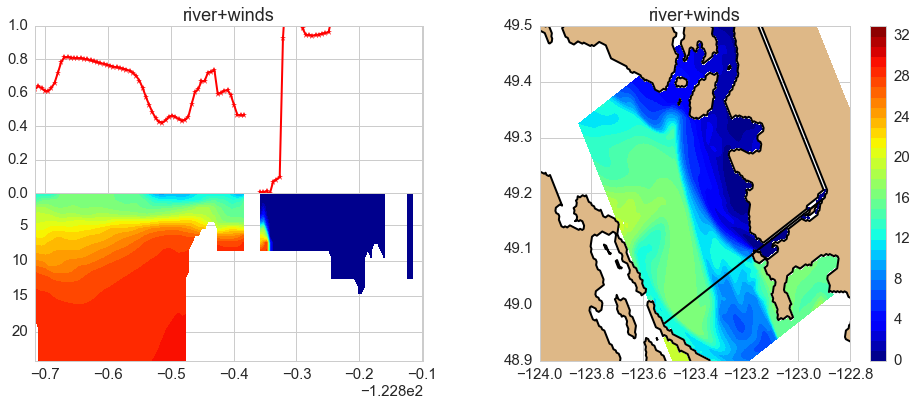

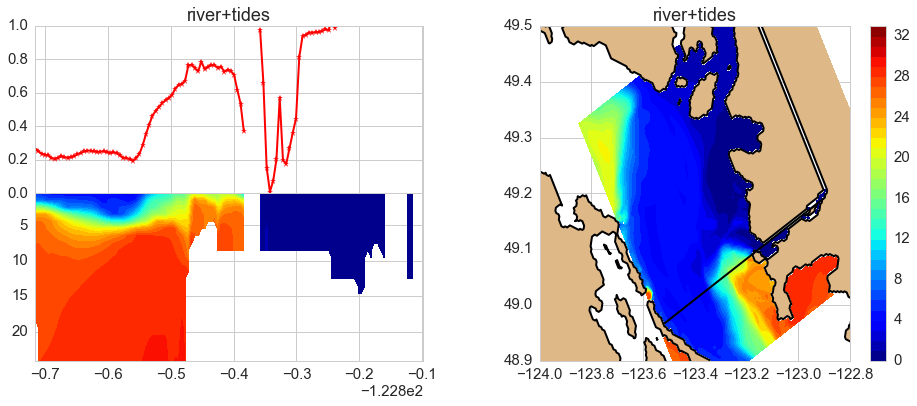

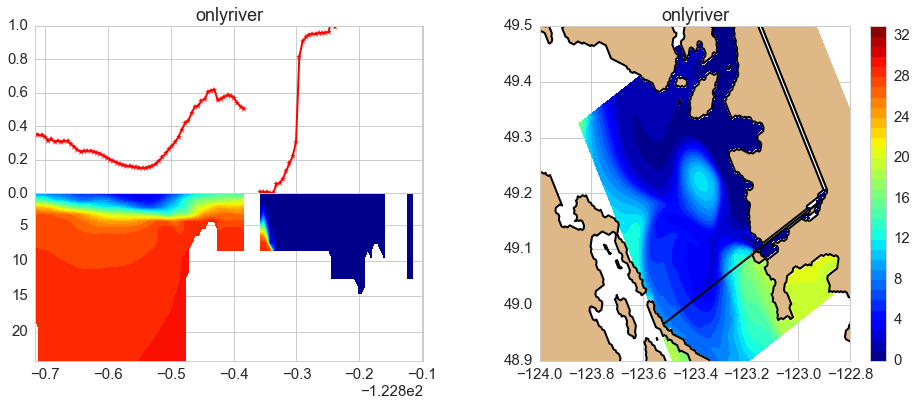

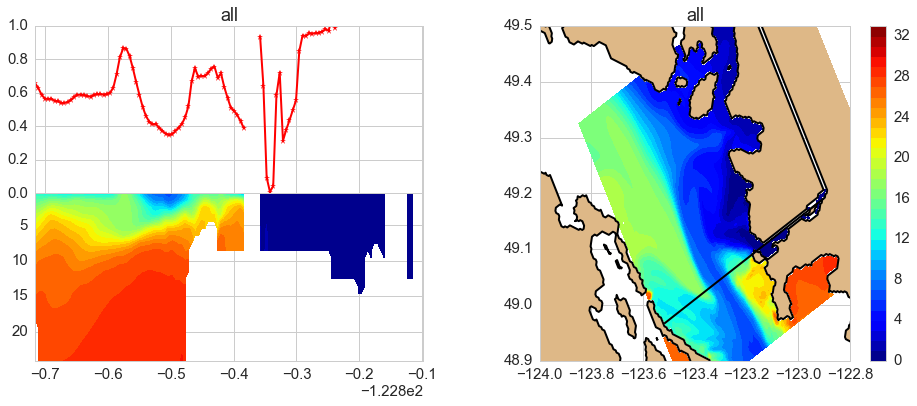

In [13]:
## instantaneous time in May, slack
r_winds, S_ave_wind = salinity_profile_update(maynotide_T,738,738,10,np_mask,'river+winds')
r_tide,S_ave_tide = salinity_profile_update(maynowind_T,738,738,10,np_mask,'river+tides')
r_river,S_ave_river = salinity_profile_update(mayriver_T,738,738,10,np_mask,'onlyriver')
r_all,S_ave_all = salinity_profile_update(mayall_T,738,738,10,np_mask,'all')

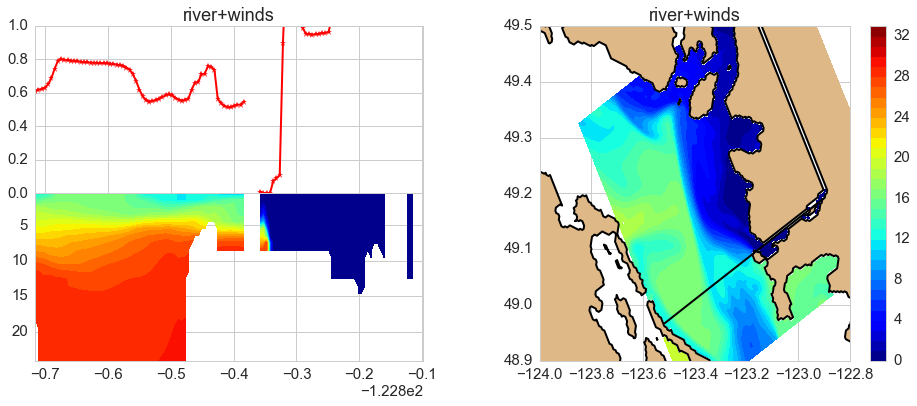

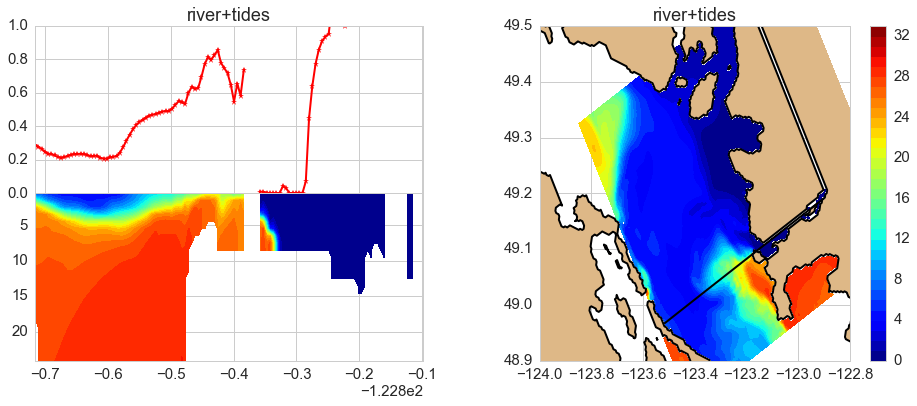

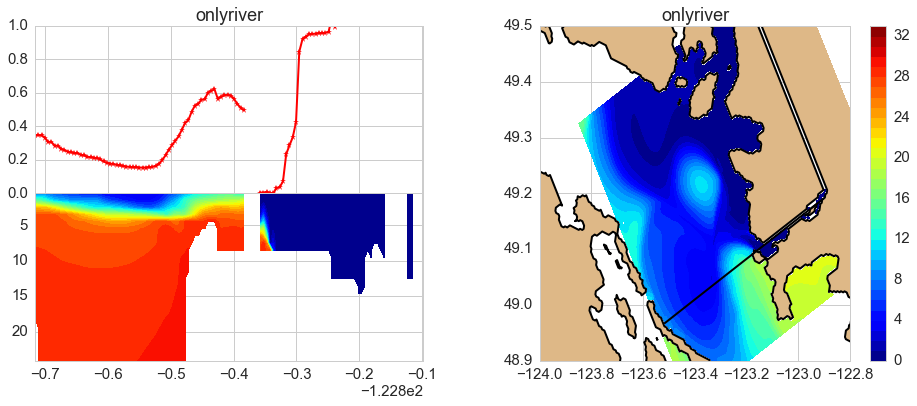

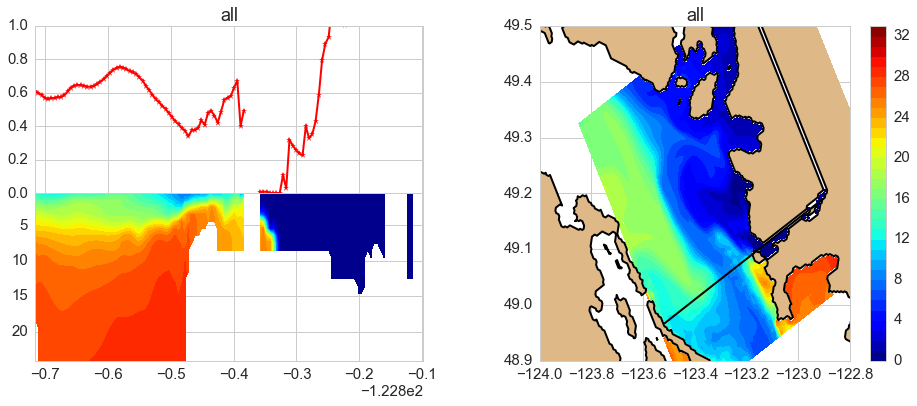

In [14]:
## instantaneous time in May, peak flood
r_winds, S_ave_wind = salinity_profile_update(maynotide_T,743,743,10,np_mask,'river+winds')
r_tide,S_ave_tide = salinity_profile_update(maynowind_T,743,743,10,np_mask,'river+tides')
r_river,S_ave_river = salinity_profile_update(mayriver_T,743,743,10,np_mask,'onlyriver')
r_all,S_ave_all = salinity_profile_update(mayall_T,743,743,10,np_mask,'all')